In [1]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d atharvaingle/crop-recommendation-dataset

100% 63.7k/63.7k [00:00<00:00, 598kB/s]
100% 63.7k/63.7k [00:00<00:00, 597kB/s]


In [4]:
! unzip /content/crop-recommendation-dataset.zip

Archive:  /content/crop-recommendation-dataset.zip
  inflating: Crop_recommendation.csv  


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm 
import seaborn as sn
from sklearn import metrics, preprocessing, model_selection
import keras_tuner as kt

# Read the Data

In [6]:
dataset = pd.read_csv('/content/Crop_recommendation.csv')
dataset 

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [7]:
# show the dataset information 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


# Preprocessing the Dataset 

In [8]:
# drop the na values 
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 154.7+ KB


In [9]:
dataset

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


array([[<AxesSubplot:title={'center':'N'}>,
        <AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'ph'}>],
       [<AxesSubplot:title={'center':'rainfall'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

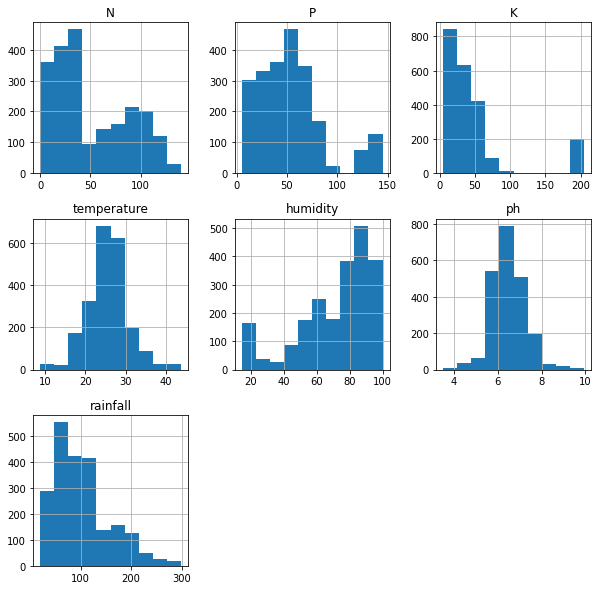

In [10]:
# plot the histogram 
dataset.hist(figsize=(10,10))

In [11]:
dataset.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [12]:
dataset

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [13]:
dataset 

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [14]:
dataset .iloc[0]

N                      90
P                      42
K                      43
temperature     20.879744
humidity        82.002744
ph               6.502985
rainfall       202.935536
label                rice
Name: 0, dtype: object

In [15]:

dataset.label=dataset.label.factorize()[0]

In [16]:
# split the data to features and labels 
x=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]


In [17]:
# scale the feature values between 0,1
min_max_preprocess =preprocessing.StandardScaler()
min_max_preprocess.fit(x)
x_norm=min_max_preprocess.transform(x)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

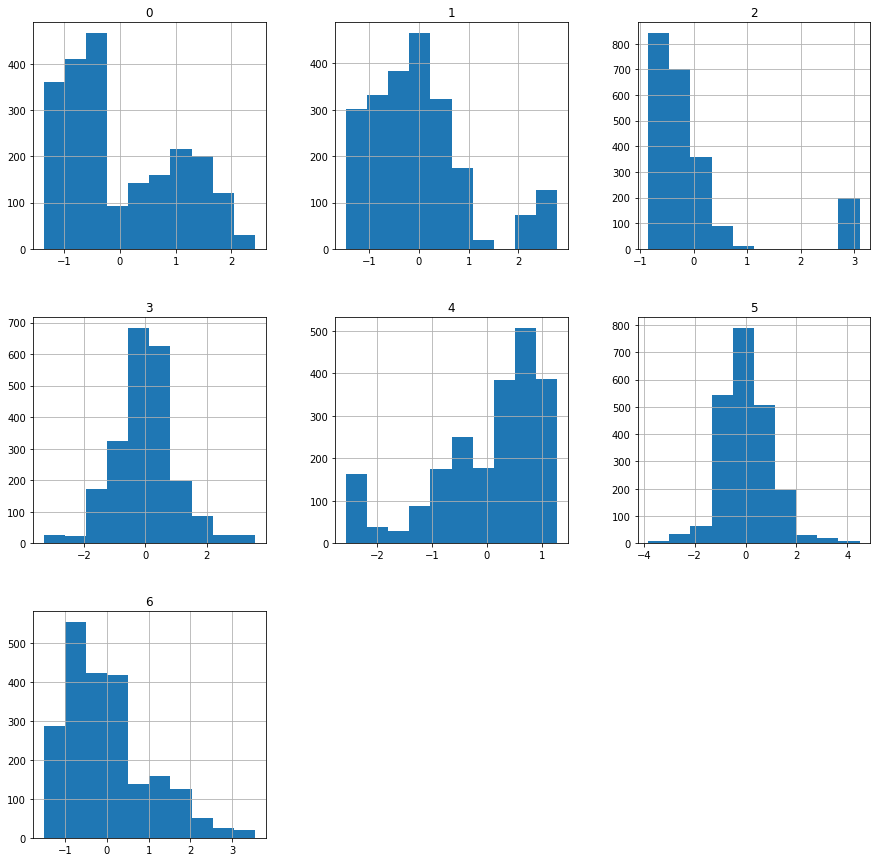

In [18]:
pd.DataFrame(x_norm).hist(figsize=(15,15))

(array([300., 200., 200., 200., 200., 200., 200., 200., 200., 300.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <BarContainer object of 10 artists>)

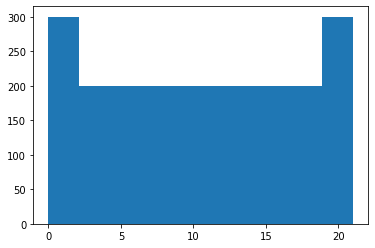

In [19]:
plt.hist(y)

In [20]:
len(set(y))

22

# Spilt the Data to Train & Test 

In [21]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(x_norm,y,test_size=0.2,random_state=42,stratify=y)

In [22]:
y_train = tf.one_hot(y_train,depth=len(set(y)))
y_test = tf.one_hot(y_test,depth=len(set(y)))

# Create the Data Pipeline

In [23]:
# creat the data pipeline
def data_pipeline(x,y,batch_size=32):
    # insert the data to the data pipeline
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(50000)# shuffle the data
    data=data.batch(batch_size)# creat the batch
    data=data.prefetch(tf.data.AUTOTUNE)# run the data processing and training in parallel 
    return data

In [24]:
# create the train pipeline 
train_dataset=data_pipeline(x_train,y_train)
# create the test pipeline
test_dataset=data_pipeline(x_test,y_test)

In [25]:
# get the first batch of data from the train pipeline 
for x,y in train_dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[[ 1.04170369e+00 -8.60039908e-01  1.15547451e-01 -1.82229476e-01
   6.32914984e-01 -1.50398580e-01 -9.91334213e-01]
 [ 1.20426592e+00  6.56104678e-01  3.65529228e-02  4.86986576e-01
   1.69934018e-01 -1.09318450e+00  2.69583989e-01]
 [ 1.63776520e+00  7.77396245e-01  9.57988193e-02  5.32471615e-01
   1.92816681e-01 -3.93504562e-01  2.95419869e-01]
 [ 9.06235169e-01 -4.05196532e-01 -1.01687502e-01 -1.19438341e-01
   7.56984210e-01  9.80648294e-01  1.20032887e+00]
 [ 2.28892546e-01  2.61907086e-01  7.60501871e-02  3.56719032e+00
   9.71622038e-01  1.79884331e-01  6.55026866e-03]
 [-6.11012308e-01  6.86427570e-01  6.68509152e-01 -9.97556095e-01
  -2.57084233e+00  2.39020919e-01 -3.58612477e-01]
 [-5.56824898e-01 -1.40585196e+00 -6.54649203e-01  1.50481822e+00
   8.79598319e-01  1.75254438e+00  2.23899064e-01]
 [-6.11012308e-01 -1.62613398e-01 -6.54649203e-01 -8.98728965e-02
  -7.29035578e-01  3.59879419e+00 -1.13868972e+00]
 [-7.73574537e-01 -5.26488099e-01 -6.34900571e-01  9.

# Model

In [26]:
class Model(tf.keras.Model):
    def __init__(self,units_tuner,activation_tuner,kernel_regularizer_tuner,dropout_tuner):
        super(Model,self).__init__()
        self.dropout_tuner=dropout_tuner
        activation_tuner=[tf.nn.relu,tf.nn.leaky_relu,tf.nn.elu][activation_tuner]


        self.D1=tf.keras.layers.Dense(units_tuner[0],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[0],name='D1')
        self.D1_dropout = tf.keras.layers.Dropout(0.3)
        self.D2=tf.keras.layers.Dense(units_tuner[1],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[1],name='D2')
        self.D2_dropout = tf.keras.layers.Dropout(0.3)
        self.D3=tf.keras.layers.Dense(units_tuner[2],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[2],name='D3')
        self.D3_dropout = tf.keras.layers.Dropout(0.3)
        self.D4=tf.keras.layers.Dense(units_tuner[3],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[3],name='D4')
        self.D4_dropout = tf.keras.layers.Dropout(0.3)
        self.D5=tf.keras.layers.Dense(units_tuner[4],activation=activation_tuner,kernel_regularizer=kernel_regularizer_tuner[4],name='D5')
        self.D5_dropout = tf.keras.layers.Dropout(0.3)
        self.out=tf.keras.layers.Dense(22,activation=tf.nn.softmax,name='out')
    def call(self,x ):
        x=self.D1(x)
        if self.dropout_tuner:
            x=self.D1_dropout(x)
        x=self.D2(x)
        if self.dropout_tuner:
            x=self.D2_dropout(x)
        x=self.D3(x)
        if self.dropout_tuner:
            x=self.D3_dropout(x)
        x=self.D4(x)
        if self.dropout_tuner:
            x=self.D4_dropout(x)
        x=self.D5(x)
        if self.dropout_tuner:
            x=self.D5_dropout(x)
        out = self.out(x)
        return out


In [27]:
def model_builder(hp):
    # define the kernel values tuner 
    units_tuner=[hp.Int('D1', min_value=8, max_value=512, step=32),
                  hp.Int('D2', min_value=8, max_value=512, step=32),
                  hp.Int('D3', min_value=8, max_value=512, step=32),
                  hp.Int('D4', min_value=8, max_value=512, step=32),
                  hp.Int('D5', min_value=8, max_value=512, step=32)]
                 
    # define the activation function tuner 
    activation_tuner = hp.Choice('activation',[0,1,2])

    # define the kernel_regularizer_tuner
    kernel_regularizer_tuner=[hp.Choice('regularizer_1',['L1','L2','L1L2']),
                              hp.Choice('regularizer_2',['L1','L2','L1L2']),
                              hp.Choice('regularizer_3',['L1','L2','L1L2']),
                              hp.Choice('regularizer_4',['L1','L2','L1L2']),
                              hp.Choice('regularizer_5',['L1','L2','L1L2']),
                              ]
    # define the dropout_tuner
    dropout_tuner= hp.Choice('dropout',[True,False])
    
    
    model = Model(
                      units_tuner=units_tuner,
                      activation_tuner=activation_tuner,
                      kernel_regularizer_tuner=kernel_regularizer_tuner,
                      dropout_tuner=dropout_tuner,
                     
                      )
    
    model.build((None,7))# build the model 
    
    # define the learning rate tuner 
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # compile the model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"]
    )
    return model 

In [28]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     max_trials=10,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [30]:
tuner.search(train_dataset, epochs=50,validation_data=test_dataset , callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 00m 25s]
val_loss: 0.6508758664131165

Best val_loss So Far: 0.22228558361530304
Total elapsed time: 00h 04m 15s


In [31]:
a=tuner.get_best_hyperparameters()[0]
a.values

{'D1': 8,
 'D2': 360,
 'D3': 232,
 'D4': 456,
 'D5': 456,
 'activation': 2,
 'regularizer_1': 'L1L2',
 'regularizer_2': 'L2',
 'regularizer_3': 'L2',
 'regularizer_4': 'L1L2',
 'regularizer_5': 'L1L2',
 'dropout': 0,
 'lr': 0.00010771477620806375}

## Model Evaluation 

In [32]:
#Get optimal hyperparameters and models from the tuner
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 D1 (Dense)                  multiple                  64        
                                                                 
 dropout_5 (Dropout)         multiple                  0 (unused)
                                                                 
 D2 (Dense)                  multiple                  3240      
                                                                 
 dropout_6 (Dropout)         multiple                  0 (unused)
                                                                 
 D3 (Dense)                  multiple                  83752     
                                                                 
 dropout_7 (Dropout)         multiple                  0 (unused)
                                                                 
 D4 (Dense)                  multiple                  1062

In [34]:
model.fit(train_dataset,epochs=50,validation_data=test_dataset)

Epoch 1/50
55/55 [==============================] - 4s 9ms/step - loss: 5.2295 - accuracy: 0.4705 - val_loss: 4.4706 - val_accuracy: 0.6614
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 3.9806 - accuracy: 0.6847 - val_loss: 3.5761 - val_accuracy: 0.7432
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 3.3007 - accuracy: 0.7744 - val_loss: 3.0569 - val_accuracy: 0.8136
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 2.8593 - accuracy: 0.8267 - val_loss: 2.6686 - val_accuracy: 0.8477
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 2.5119 - accuracy: 0.8528 - val_loss: 2.3613 - val_accuracy: 0.8659
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 2.2272 - accuracy: 0.8915 - val_loss: 2.1107 - val_accuracy: 0.8795
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 1.9920 - accuracy: 0.8983 - val_loss: 1.8848 - val_accuracy: 0.9227
Epoch 8/50
55/55 [==

<AxesSubplot:>

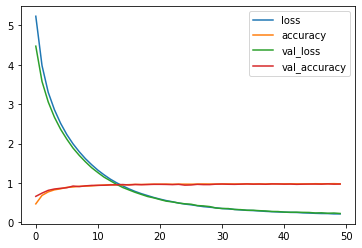

In [35]:
pd.DataFrame(model.history.history).plot()

In [36]:
preds=np.array([])
ys=np.array([])
for x,y in tqdm.tqdm(test_dataset):
    pred = model.predict(x)
    pred = np.argmax(pred ,axis =-1)
    preds=np.append(preds,pred)
    y = np.argmax(y,axis=-1)
    ys=np.append(ys,y)
    
    
    
    

  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 1/14 [00:00<00:02,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 3/14 [00:00<00:01, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 5/14 [00:00<00:00, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 7/14 [00:00<00:00, 12.93it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 9/14 [00:00<00:00, 14.09it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 11/14 [00:00<00:00, 14.63it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 13/14 [00:00<00:00, 15.25it/s]

1/1 [==============================] - 0s 88ms/step


100%|██████████| 14/14 [00:01<00:00, 12.59it/s]


accuracy_score: 0.9727272727272728
precision_score: 0.9741374786829331
recall_score: 0.9727272727272728
f1_score: 0.972678861574882


<AxesSubplot:>

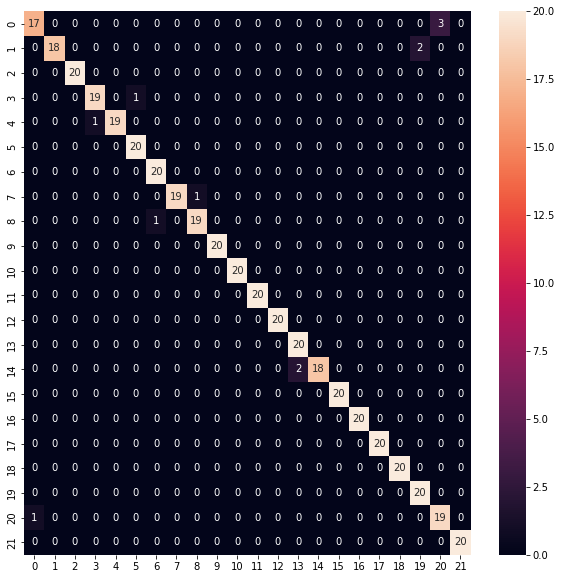

In [37]:
accuracy_score=metrics.accuracy_score(y_true=ys,y_pred=preds)
precision_score=metrics.precision_score(ys,preds,average='weighted')
recall_score=metrics.recall_score(ys,preds,average='weighted')
f1_score=metrics.f1_score(ys,preds,average='weighted')
confion_metrix=metrics.confusion_matrix(ys,preds)
print('accuracy_score:',accuracy_score)
print('precision_score:',precision_score)
print('recall_score:',recall_score)
print('f1_score:',f1_score)
plt.figure(figsize=(10,10))
sn.heatmap(confion_metrix,annot=True,)